# Working with a downsampled TSNV_24 dataset
## Featuring only data since 2008

It is suspected that the experimental models work fine only because the dataset is smaller. This notebook serves to confirm/debunk the suspicion by re-fitting every model shown in `baseline__overview_full_ds.ipynb` (and perhaps more models too) using a downsized TSNV_24 dataset. Please also look at that notebook and `experimental__overview.ipynb`.

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import pandas as pd
import xgboost as xgb
import sys
import os
import matplotlib.pyplot as plt

warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [2]:
from sklearn.model_selection import train_test_split

def separateDataset(dataset, train_ratio):
    '''
    Takes in a dataset (pandas df) and a ratio value, returns a dictionary containing the separated dataset.
    Key "train" = train set, "dev" = dev set (size = train ratio * (sizeof input df - test set)), "test" = test set (size = train ratio * sizeof input df)
    '''
    train_dev_set, test_set = train_test_split(dataset, train_size=train_ratio, random_state=42)
    train_set, dev_set = train_test_split(train_dev_set, train_size=train_ratio, random_state=42)
    print("Training set size: {0}; Dev set size: {1}; Testing set size: {2}".format(len(train_set), len(dev_set), len(test_set)))
    return { "train": train_set, "dev": dev_set, "test": test_set }

def pandasToXY(dataframe):
    '''
    converts the given pandas df to X and Y sub-arrays. X is pandas df, Y is np int array.
    note: the range of columns to select as Y must be double checked when a different dataset is used.
    '''
    X = dataframe.drop(['LOW_IMPACT', 'MID_IMPACT', 'BIG_IMPACT', 'DIRECT_STRIKE'], axis=1)
    Y = np.asarray(dataframe.iloc[:,:4]).astype(int)
    return X, Y

dataset = pd.read_pickle('../Dataset/baseline_dataset_tsnv_2008_24.gz')
# train-dev-test splitting
splitDataset = separateDataset(dataset, 0.9)
# separate each of the 3 sets into X and Y
train_full = splitDataset["train"]
train_X, train_Y = pandasToXY(train_full)
dev_full = splitDataset["dev"]
dev_X, dev_Y = pandasToXY(dev_full)
test_full = splitDataset["test"]
test_X, test_Y = pandasToXY(test_full)

Training set size: 5634; Dev set size: 627; Testing set size: 696


In [3]:
train_X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5634 entries, 4165 to 5428
Data columns (total 64 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MM00         5634 non-null   int32  
 1   DD00         5634 non-null   int32  
 2   HH00         5634 non-null   int32  
 3   MI_STATUS00  5634 non-null   bool   
 4   LI_STATUS00  5634 non-null   bool   
 5   SI_STATUS00  5634 non-null   bool   
 6   DS_STATUS00  5634 non-null   bool   
 7   DIST00       5634 non-null   float64
 8   AZM00        5634 non-null   float64
 9   SPEED00      5634 non-null   int32  
 10  DIR00        5634 non-null   int32  
 11  VMAX00       5634 non-null   int32  
 12  DVMAX00      5634 non-null   int32  
 13  MM06         5634 non-null   int32  
 14  DD06         5634 non-null   int32  
 15  HH06         5634 non-null   int32  
 16  MI_STATUS06  5634 non-null   bool   
 17  LI_STATUS06  5634 non-null   bool   
 18  SI_STATUS06  5634 non-null   bool   
 19  DS_

In [4]:
print("Null checking:")
print(dataset[dataset.isnull().any(axis=1)])

Null checking:
Empty DataFrame
Columns: [LOW_IMPACT, MID_IMPACT, BIG_IMPACT, DIRECT_STRIKE, MM00, DD00, HH00, MI_STATUS00, LI_STATUS00, SI_STATUS00, DS_STATUS00, DIST00, AZM00, SPEED00, DIR00, VMAX00, DVMAX00, MM06, DD06, HH06, MI_STATUS06, LI_STATUS06, SI_STATUS06, DS_STATUS06, DIST06, AZM06, SPEED06, DIR06, VMAX06, DVMAX06, MM12, DD12, HH12, MI_STATUS12, LI_STATUS12, SI_STATUS12, DS_STATUS12, DIST12, AZM12, SPEED12, DIR12, VMAX12, DVMAX12, MM18, DD18, HH18, MI_STATUS18, LI_STATUS18, SI_STATUS18, DS_STATUS18, DIST18, AZM18, SPEED18, DIR18, VMAX18, DVMAX18, MM24, DD24, HH24, MI_STATUS24, LI_STATUS24, SI_STATUS24, DS_STATUS24, DIST24, AZM24, SPEED24, DIR24, VMAX24]
Index: []

[0 rows x 68 columns]


## Helper functions

In [5]:
from sklearn.multioutput import MultiOutputClassifier, MultiOutputRegressor
from sklearn.metrics import precision_recall_curve, classification_report, f1_score, precision_score, recall_score, accuracy_score

In [6]:
def optimize_thresholds(clf, dataset_X, dataset_Y):
    '''
    Takes in a classifier, an input set X and a target set Y; returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    # find the best decision thresholds and the corresponding F1 scores
    all_preds = np.array(clf.predict_proba(dataset_X))
    best_thresholds = []
    best_f1_scores = []
    n_classes = len(clf.classes_)
    for i in range(n_classes):
        if isinstance(clf, MultiOutputClassifier):
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[i,:,1])
        else:
            precision, recall, thresholds = precision_recall_curve(dataset_Y[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the last class/label
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

In [7]:
def predictions_with_thresholds(clf, thresholds, dataset_X):
    '''
    Takes in a classifier, a list of decision thresholds and an input samples set X;
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    preds_probs = np.array(clf.predict_proba(dataset_X))
    n_classes = len(clf.classes_)
    preds = []
    # iterate each predicted probability and compare against threshold
    if isinstance(clf, MultiOutputClassifier):
        for i in range(preds_probs.shape[1]):
                pred_row = []
                for j in range(n_classes):
                    if preds_probs[j,i,1] > thresholds[j]:
                        pred_row.append(1)
                    else:
                        pred_row.append(0)
                preds.append(pred_row)
    else:
        for i in range(preds_probs.shape[0]):
            pred_row = []
            for j in range(n_classes):
                if preds_probs[i,j] > thresholds[j]:
                    pred_row.append(1)
                else:
                    pred_row.append(0)
            preds.append(pred_row)        
    
    return np.array(preds)

In [8]:
from scipy.special import expit

def regression_predict(regr, datasetX, method='clip'):
    '''
    Takes in a regressor, an input samples set X and optionally a method argument (must be either "sigmoid" or "clip");
    Returns predictions made by the regressor on X that have been rescaled to fall within [0,1] using the specified method.
    '''
    # method specifies how to handle inputs outside of 0-1 range: clip to 0 or 1, or pass through sigmoid
    preds = regr.predict(datasetX)
    if method == 'clip':
        preds = np.clip(preds, 0, 1)
    elif method == 'sigmoid':
        preds = expit(preds)
    return preds

def regressor_find_thresholds(regr, datasetX, datasetY, method='clip', probs_given=False, probs=None):
    '''
    Takes in a regressor, an input set X, a target set Y and optionally a scaling method;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    returns the best decision thresholds and corresponding f1-scores;
    displays the values and a precision recall curve.
    '''
    if probs_given:
        all_preds = probs
    else:
        all_preds = regression_predict(regr, datasetX, method)
    best_thresholds = []
    best_f1_scores = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(datasetY[:,i], all_preds[:,i])
        # find best threshold
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
        best_f1_scores.append(fscore[ix])
        print('Best Threshold={0:.05f}, F-Score={1:.05f}'.format(thresholds[ix], fscore[ix]))

    # plot the precision-recall curve for the model
    plt.plot(recall, precision, marker='.', label='PR curve')
    plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Direct Strike')
    plt.legend()
    
    return best_thresholds, best_f1_scores

def regression_label(regr, datasetX, thresholds, method='clip', probs_given=False, probs=None):
    '''
    Takes in a regressor, a list of decision thresholds, an input samples set X and optionally a scaling method;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    Returns deterministic predictions made using the model over X and the thresholds.
    '''
    if probs_given:
        preds_probs = probs
    else:
        preds_probs = regression_predict(regr, datasetX, method)
    preds = []
    # iterate each predicted probability and compare against threshold
    for i in range(len(preds_probs)):
        pred_row = []
        for j in range(4):
            if preds_probs[i,j] > thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    
    return np.array(preds)

In [9]:
from sklearn.metrics import brier_score_loss
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from matplotlib.gridspec import GridSpec

def calibration_plot(clf, dataset_X, dataset_Y, probs_given=False, probs=None):
    '''
    Takes in a classifier, an input set X and a target set Y;
    optionally accepts a given matrix of predicted probabilities (probs_given=True, probs=...);
    Calculates and shows Brier scores and plots calibration graphs for reference.
    '''
    # brier score loss
    print("Brier score losses: (the smaller the better)")  
    if probs_given:
        all_preds = probs
    elif isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    for i in range(4):
        if isinstance(clf, MultiOutputClassifier):
            preds = all_preds[i,:,1]
        else:            
            preds = all_preds[:,i]
        clf_score = brier_score_loss(dataset_Y[:,i], preds)
        print("Class {0}, no calibration: {1:1.6f}".format(i, clf_score))

    # plot calibration graphs
    fig = plt.figure(figsize=(10, 10))
    gs = GridSpec(4, 2)
    ax = fig.add_subplot(gs[:2, :2])

    if probs_given:
        all_preds = probs
    elif isinstance(clf, MultiOutputRegressor):
        all_preds = regression_predict(clf, dataset_X)
    else:
        all_preds = np.array(clf.predict_proba(dataset_X))
    preds = all_preds[0,:,1] if isinstance(clf, MultiOutputClassifier) else all_preds[:,0]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,0], preds, n_bins=10, name="class 0", ax=ax, strategy='uniform')
    preds = all_preds[3,:,1] if isinstance(clf, MultiOutputClassifier) else all_preds[:,3]
    display = CalibrationDisplay.from_predictions(dataset_Y[:,3], preds, n_bins=10, name="class 3", ax=ax, strategy='uniform')

    ax.grid()
    plt.tight_layout()
    plt.show()

In [10]:
import joblib
from datetime import datetime

def save_sklearn_model_to_file(model, model_type, filename=None):
    '''Saves a sklearn model to file. Takes in the model, a name for the model and optionally a full filename.'''
    if filename == None:
        filename = "./models/baseline_model_{0}_{1}.skl".format(model_type, str(datetime.now().strftime("%Y-%m-%d %H-%M")))
        
    joblib.dump(model, filename)
    
    # to load a model: model = joblib.load(filename)

## Group 1: Trees
### XGBoost

No hyperparams: f1-score \[0.94017 0.93023 0.93750 0.90909\] average 0.92925  
With optimization: f1-score \[0.94828 0.95455 0.87500 0.90909\] average 0.92173  
Both of the above were saved; and then calibrated and saved again.

Regressors were not always as good, but calibration was undeniably better.  
No hyperparams: average 0.86650  
With optimization: average 0.93681

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

Best Threshold=0.41247, F-Score=0.95726
Best Threshold=0.40437, F-Score=0.94505
Best Threshold=0.46181, F-Score=0.94118
Best Threshold=0.24653, F-Score=1.00000


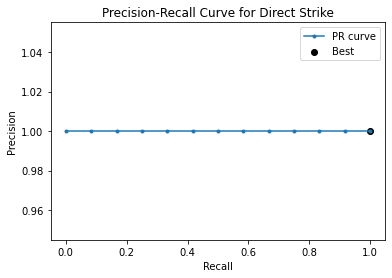

In [76]:
#xgb_clf = MultiOutputClassifier(xgb.XGBClassifier(
#    n_estimators=100, subsample=1.0, colsample_bytree=0.375, min_child_weight=0.03125, learning_rate=1.0, reg_alpha=0.0005, reg_lambda=1.0,
#    max_depth=6, gamma=5e-6, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
#), n_jobs=-1).fit(train_X, train_Y) 

xgb_clf = MultiOutputRegressor(xgb.XGBRegressor(
    max_depth=25, n_estimators=300, subsample=1.0, colsample_bytree=0.375, learning_rate=0.0625, reg_alpha=0.5, reg_lambda=10.0,
    gamma=1e-5, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1).fit(train_X, train_Y)

# best_thresholds, best_f1_scores = optimize_thresholds(xgb_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(xgb_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.010376
Class 1, no calibration: 0.008724
Class 2, no calibration: 0.005312
Class 3, no calibration: 0.002901


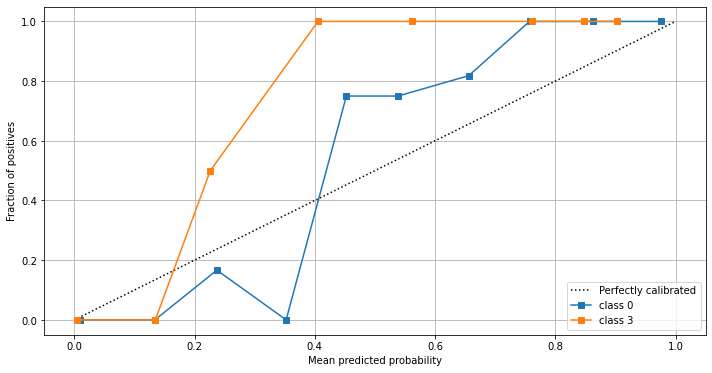

In [77]:
calibration_plot(xgb_clf, dev_X, dev_Y)

In [78]:
# preds = predictions_with_thresholds(xgb_clf, best_thresholds, dev_X)
preds = regression_label(xgb_clf, dev_X, best_thresholds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.93220   0.96491   0.94828        57
           1    0.93333   0.93333   0.93333        45
           2    0.88235   0.93750   0.90909        16
           3    1.00000   0.91667   0.95652        12

   micro avg    0.93182   0.94615   0.93893       130
   macro avg    0.93697   0.93810   0.93681       130
weighted avg    0.93272   0.94615   0.93904       130
 samples avg    0.09450   0.09649   0.09451       130



#### Real men grid search right here

(classifier)  
max_depth: from 5-25, best value 6   
subsample: from 0.25-1.0, best value 1.0  
colsample_bytree: from 0.125-1.0, best value 0.375   
min_child_weight: from 0.03125-2.0, best value 0.03125 (may be smaller)   
learning_rate: from 0.0001-10.0, best value 1.0   
reg_alpha: from 0.00001 to 0.1, best value 0.0005  
reg_lambda: from 0.00001 to 10.0, best value 1.0   
gamma: from 1.0 to 1e-6, best value 5e-6  
n_estimators: from 50-400, best value 100    

In [73]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score

#xgb_clf = MultiOutputClassifier(xgb.XGBClassifier(
#    n_estimators=100, subsample=1.0, colsample_bytree=0.375, min_child_weight=0.03125, learning_rate=1.0, reg_alpha=0.0005, reg_lambda=1.0,
#    gamma=5e-6, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
#), n_jobs=-1)

xgb_clf = MultiOutputRegressor(xgb.XGBRegressor(
    n_estimators=300, subsample=1.0, colsample_bytree=0.375, learning_rate=0.0625, reg_alpha=0.5, reg_lambda=10.0,
    gamma=1e-5, tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)

# scorer = make_scorer(f1_score, zero_division=0, average='macro')

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')
scorer = make_scorer(my_scorer)

param_grid = {"estimator__max_depth": [20, 25, 30]}

gscv = GridSearchCV(xgb_clf, param_grid, scoring=scorer, verbose=4, cv=3, n_jobs=1).fit(train_X, train_Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits
[CV 1/3] END ...........estimator__max_depth=20;, score=0.853 total time=  18.2s
[CV 2/3] END ...........estimator__max_depth=20;, score=0.886 total time=  17.9s
[CV 3/3] END ...........estimator__max_depth=20;, score=0.819 total time=  18.1s
[CV 1/3] END ...........estimator__max_depth=25;, score=0.853 total time= 1.7min
[CV 2/3] END ...........estimator__max_depth=25;, score=0.886 total time= 1.7min
[CV 3/3] END ...........estimator__max_depth=25;, score=0.818 total time= 1.7min
[CV 1/3] END .............estimator__max_depth=30;, score=nan total time=  13.4s


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV 2/3] END .............estimator__max_depth=30;, score=nan total time=  18.5s


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is depre

[CV 3/3] END .............estimator__max_depth=30;, score=nan total time=  17.3s


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
3 fits failed out of a total of 9.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
3 fits failed with the following error:
Traceback (most recent call last):
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sklearn/multioutput.py", line 202, in fit
    self.estimators_ = Parallel(n_jobs=self.n_jobs)(
  File "/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/joblib/p

In [74]:
gscv.cv_results_

{'mean_fit_time': array([ 17.39481139, 102.81329314,  16.39710681]),
 'std_fit_time': array([0.17051686, 0.11304413, 2.18998649]),
 'mean_score_time': array([0.67164373, 0.65155776, 0.        ]),
 'std_score_time': array([0.04603244, 0.06204391, 0.        ]),
 'param_estimator__max_depth': masked_array(data=[20, 25, 30],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__max_depth': 20},
  {'estimator__max_depth': 25},
  {'estimator__max_depth': 30}],
 'split0_test_score': array([0.85285416, 0.85330183,        nan]),
 'split1_test_score': array([0.8860859 , 0.88582957,        nan]),
 'split2_test_score': array([0.81882636, 0.8178267 ,        nan]),
 'mean_test_score': array([0.85258881, 0.85231937,        nan]),
 'std_test_score': array([0.02745923, 0.02777075,        nan]),
 'rank_test_score': array([1, 2, 3], dtype=int32)}

In [75]:
gscv.best_params_

{'estimator__max_depth': 20}

#### Calibration

In [14]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

# base estimator
xgb_clf = OneVsRestClassifier(xgb.XGBClassifier(
    n_estimators=100, subsample=1.0, colsample_bytree=0.375, min_child_weight=0.03125, learning_rate=1.0, reg_alpha=0.0005, reg_lambda=1.0,
    max_depth=6, gamma=5e-6, 
    tree_method='gpu_hist', n_jobs=-1, random_state=42, use_label_encoder=False, eval_metric='logloss'
), n_jobs=-1)
# calibrated estimator
xgb_clf = CalibratedClassifierCV(base_estimator=xgb_clf, cv=7, n_jobs=-1, ensemble=False)
xgb_clf = MultiOutputClassifier(xgb_clf, n_jobs=-1).fit(train_X, train_Y)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/xgb

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.012741
Class 1, no calibration: 0.005308
Class 2, no calibration: 0.006019
Class 3, no calibration: 0.002990


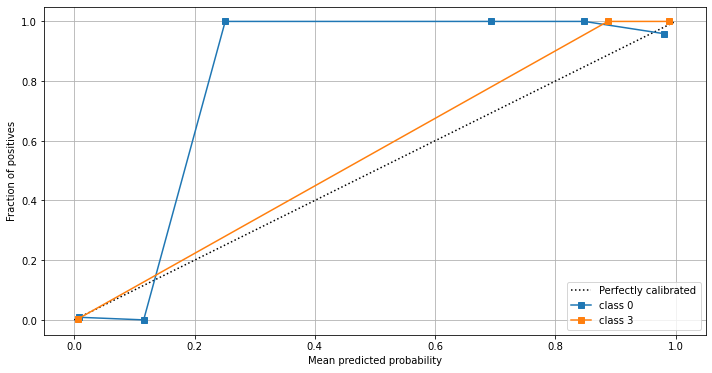

Best Threshold=0.01810, F-Score=0.95726
Best Threshold=0.44690, F-Score=0.96629
Best Threshold=0.10591, F-Score=0.90909
Best Threshold=0.07744, F-Score=0.95652
              precision    recall  f1-score   support

           0    0.93220   0.96491   0.94828        57
           1    0.97674   0.93333   0.95455        45
           2    0.87500   0.87500   0.87500        16
           3    1.00000   0.83333   0.90909        12

   micro avg    0.94531   0.93077   0.93798       130
   macro avg    0.94599   0.90164   0.92173       130
weighted avg    0.94684   0.93077   0.93781       130
 samples avg    0.09569   0.09569   0.09481       130



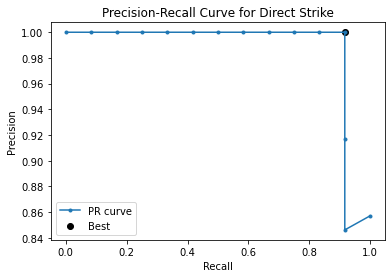

In [15]:
calibration_plot(xgb_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = optimize_thresholds(xgb_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(xgb_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [79]:
save_sklearn_model_to_file(xgb_clf, "downsampled_gscv_xgb_regr")

### ExtraTrees

No tricks: f1-score \[0.94737 0.95349 0.90909 0.95652\] average 0.94162  
Grid searched: f1-score \[0.94915 0.95556 0.93750 0.91667\] average 0.93972

Regressors: grid searched 0.92777.

Best Threshold=0.43018, F-Score=0.96552
Best Threshold=0.42667, F-Score=0.96703
Best Threshold=0.47333, F-Score=0.91429
Best Threshold=0.33333, F-Score=0.96000


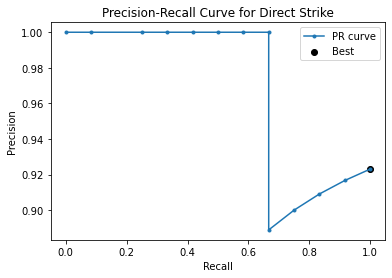

In [93]:
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

#extra_trees_clf = MultiOutputClassifier(ExtraTreesClassifier(
#    max_depth=20, max_features=50, n_estimators=150,
#    random_state=42, n_jobs=-1
#), n_jobs=-1).fit(train_X, train_Y)
extra_trees_clf = MultiOutputRegressor(
    ExtraTreesRegressor(n_estimators=150, max_depth=23, max_features=30, n_jobs=-1, random_state=42)).fit(train_X, train_Y)

# best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(extra_trees_clf, dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.008686
Class 1, no calibration: 0.006829
Class 2, no calibration: 0.004912
Class 3, no calibration: 0.004207


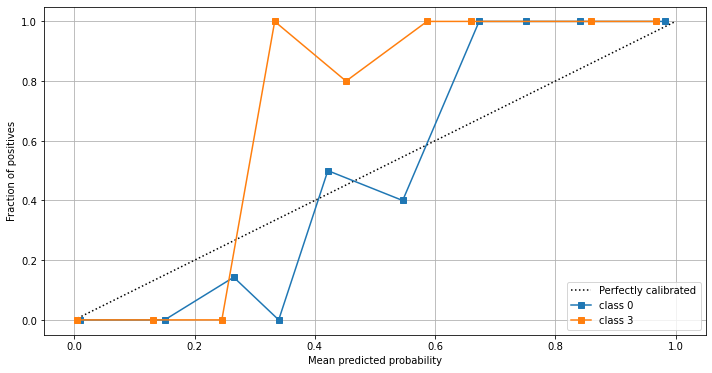

In [94]:
calibration_plot(extra_trees_clf, dev_X, dev_Y)

In [95]:
# preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, dev_X)
preds = regression_label(extra_trees_clf, dev_X, best_thresholds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.94828   0.96491   0.95652        57
           1    0.95556   0.95556   0.95556        45
           2    0.83333   0.93750   0.88235        16
           3    0.91667   0.91667   0.91667        12

   micro avg    0.93233   0.95385   0.94297       130
   macro avg    0.91346   0.94366   0.92777       130
weighted avg    0.93373   0.95385   0.94338       130
 samples avg    0.09476   0.09649   0.09480       130



#### Grid search

(classifier)  
max_features: from 10-60, best value 50   
max_depth: from 5-25, best value 20  
n_estimators: from 50-200, best value 150

In [90]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, f1_score
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor

param_grid = {"estimator__n_estimators": [50, 100, 150, 200]}
# estimator = MultiOutputClassifier(ExtraTreesClassifier(max_depth=20, max_features=50, n_jobs=-1, random_state=42))
estimator = MultiOutputRegressor(ExtraTreesRegressor(max_depth=23, max_features=30, n_jobs=-1, random_state=42))

#scorer = make_scorer(f1_score, zero_division=0, average='macro')

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')
scorer = make_scorer(my_scorer)

gscv = GridSearchCV(estimator, param_grid, scoring=scorer, n_jobs=-1, verbose=4, cv=4, error_score=0.0, refit=False).fit(train_X, train_Y)

Fitting 4 folds for each of 4 candidates, totalling 16 fits


In [91]:
gscv.cv_results_

{'mean_fit_time': array([2.01749283, 3.31320816, 5.11900681, 5.992495  ]),
 'std_fit_time': array([0.02138918, 0.13976291, 0.07246402, 0.05464536]),
 'mean_score_time': array([0.54955482, 0.69626731, 0.82877326, 0.57578385]),
 'std_score_time': array([0.04231597, 0.07911295, 0.09362456, 0.03617129]),
 'param_estimator__n_estimators': masked_array(data=[50, 100, 150, 200],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__n_estimators': 50},
  {'estimator__n_estimators': 100},
  {'estimator__n_estimators': 150},
  {'estimator__n_estimators': 200}],
 'split0_test_score': array([0.89202686, 0.88480379, 0.89200457, 0.88639281]),
 'split1_test_score': array([0.90855151, 0.91261539, 0.9114803 , 0.91152643]),
 'split2_test_score': array([0.87430565, 0.87857503, 0.88245186, 0.88828835]),
 'split3_test_score': array([0.86027619, 0.86476991, 0.8637583 , 0.86152769]),
 'mean_test_score': array([0.88379005, 0.88519103, 0.8

In [92]:
gscv.best_params_

{'estimator__n_estimators': 150}

#### Calibration
Quite unnecessary.

In [119]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

# base estimator
extra_trees_clf = OneVsRestClassifier(ExtraTreesClassifier(
    max_depth=20, max_features=50, n_estimators=150,
    random_state=42, n_jobs=-1
), n_jobs=-1)
# calibrated estimator
extra_trees_clf = CalibratedClassifierCV(base_estimator=extra_trees_clf, cv=7, n_jobs=-1, ensemble=False)
extra_trees_clf = MultiOutputClassifier(extra_trees_clf, n_jobs=-1).fit(train_X, train_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.006329
Class 1, no calibration: 0.005353
Class 2, no calibration: 0.003108
Class 3, no calibration: 0.001508


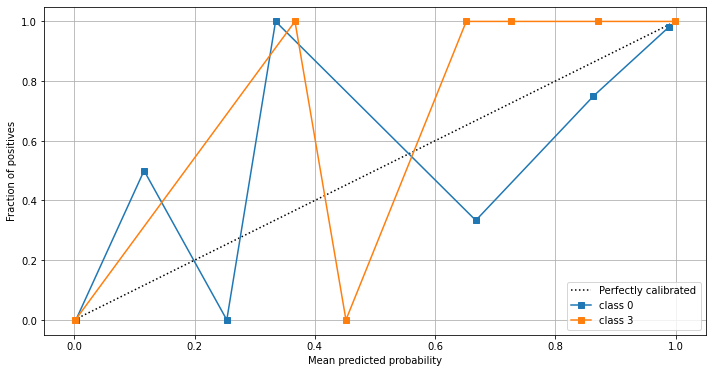

Best Threshold=0.12142, F-Score=0.95798
Best Threshold=0.40518, F-Score=0.96703
Best Threshold=0.82980, F-Score=0.96970
Best Threshold=0.36705, F-Score=0.96000
              precision    recall  f1-score   support

           0    0.91803   0.98246   0.94915        57
           1    0.95556   0.95556   0.95556        45
           2    0.93750   0.93750   0.93750        16
           3    0.91667   0.91667   0.91667        12

   micro avg    0.93284   0.96154   0.94697       130
   macro avg    0.93194   0.94804   0.93972       130
weighted avg    0.93329   0.96154   0.94694       130
 samples avg    0.09702   0.09809   0.09680       130



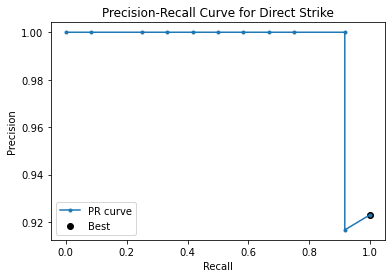

In [120]:
calibration_plot(extra_trees_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = optimize_thresholds(extra_trees_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(extra_trees_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [96]:
save_sklearn_model_to_file(extra_trees_clf, "downsampled_gscv_extra_trees_regr")

## Group 2: MLP
Interestingly it shows similar behaviour to the experimental MLP, so MLP prefers *more* data, unlike the rest of everybody. Let's drop the batch size real low for fun and see what happens.

hidden_layer_sizes=(3072, 1024, 256), batch_size=32: f1-score \[0.74016 0.76190 0.72727 0.80000\] average 0.75733  
above but LBFGS: problem is unconstrained, probably cannot fit as efficiently as adam. Testing other stuff more worthwhile.  
hidden_layer_sizes=(3072, 1024, 1024, 1024, 256): f1-score  \[0.77228 0.81928 0.90323 0.85714\] average 0.83798  
above but batch size 16: took waaaay longer, jeez, f1-score \[0.71560 0.75000 0.76471 0.76923\] average 0.74988   

regressor

In [11]:
from sklearn.neural_network import MLPClassifier, MLPRegressor

mlp_clf = MLPRegressor(
    hidden_layer_sizes=(3072, 1024, 1024, 1024, 256),
    batch_size=16,
    alpha=0.01,
    random_state=42,
    max_iter=400,
    shuffle=True,
    verbose=True
)

mlp_clf = mlp_clf.fit(train_X, train_Y)

Iteration 1, loss = 568.97065649
Iteration 2, loss = 3.39970413
Iteration 3, loss = 0.67055539
Iteration 4, loss = 0.66545613
Iteration 5, loss = 0.65500717
Iteration 6, loss = 0.65448717
Iteration 7, loss = 0.65666756
Iteration 8, loss = 0.64876640
Iteration 9, loss = 0.65102099
Iteration 10, loss = 0.63460400
Iteration 11, loss = 0.63621199
Iteration 12, loss = 0.64292972
Iteration 13, loss = 0.63774372
Iteration 14, loss = 0.62017891
Iteration 15, loss = 0.60716142
Iteration 16, loss = 0.60835661
Iteration 17, loss = 0.59807285
Iteration 18, loss = 0.59025016
Iteration 19, loss = 0.58486521
Iteration 20, loss = 0.58529410
Iteration 21, loss = 0.57830075
Iteration 22, loss = 0.57038470
Iteration 23, loss = 0.56247186
Iteration 24, loss = 0.55688355
Iteration 25, loss = 0.57341284
Iteration 26, loss = 0.56701942
Iteration 27, loss = 0.54291465
Iteration 28, loss = 0.53446741
Iteration 29, loss = 0.52669517
Iteration 30, loss = 0.51853753
Iteration 31, loss = 0.50928145
Iteration 32, l

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.049068
Class 1, no calibration: 0.035493
Class 2, no calibration: 0.014979
Class 3, no calibration: 0.011087


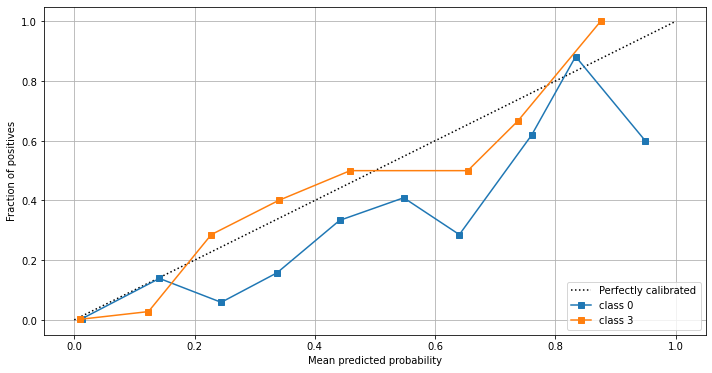

In [12]:
calibration_plot(mlp_clf, dev_X, dev_Y, probs_given=True, probs=np.clip(mlp_clf.predict(dev_X),0,1))

Best Threshold=0.34670, F-Score=0.67123
Best Threshold=0.46906, F-Score=0.69474
Best Threshold=0.39515, F-Score=0.64706
Best Threshold=0.39331, F-Score=0.63636
              precision    recall  f1-score   support

           0    0.54545   0.84211   0.66207        57
           1    0.65306   0.71111   0.68085        45
           2    0.58824   0.62500   0.60606        16
           3    0.66667   0.50000   0.57143        12

   micro avg    0.58896   0.73846   0.65529       130
   macro avg    0.61335   0.66955   0.63010       130
weighted avg    0.59916   0.73846   0.65331       130
 samples avg    0.07177   0.07443   0.06970       130



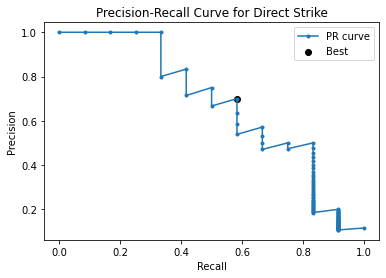

In [13]:
best_thresholds, best_f1_scores = regressor_find_thresholds(mlp_clf, dev_X, dev_Y) # optimize_thresholds(mlp_clf, dev_X, dev_Y)
preds = regression_label(mlp_clf, dev_X, best_thresholds) # predictions_with_thresholds(mlp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

#### Calibration
This is not so easy because the given classifier takes ages to fit.

In [14]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multioutput import MultiOutputClassifier

# calibrated estimator
calibrated_mlp_clf = CalibratedClassifierCV(base_estimator=mlp_clf, cv='prefit', n_jobs=-1, ensemble=False).fit(dev_X, dev_Y)
# extra_trees_clf = MultiOutputClassifier(extra_trees_clf, n_jobs=-1).fit(train_X, train_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.225805
Class 1, no calibration: 0.145883
Class 2, no calibration: 0.024648
Class 3, no calibration: 0.020510


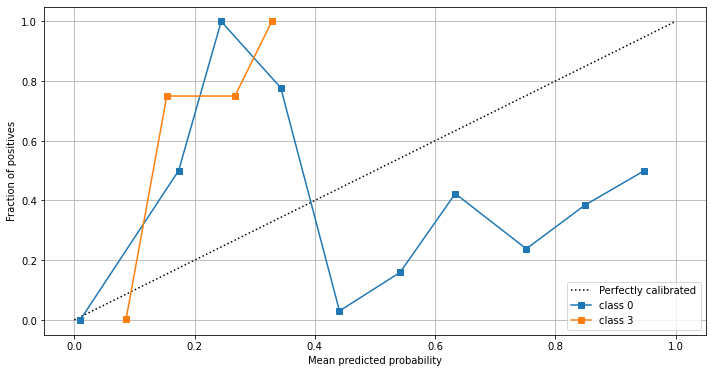

Best Threshold=0.47577, F-Score=0.42932
Best Threshold=0.37849, F-Score=0.49275
Best Threshold=0.10790, F-Score=0.77778
Best Threshold=0.11478, F-Score=0.80000
              precision    recall  f1-score   support

           0    0.30075   0.70175   0.42105        57
           1    0.69565   0.35556   0.47059        45
           2    0.68421   0.81250   0.74286        16
           3    0.75000   0.75000   0.75000        12

   micro avg    0.41711   0.60000   0.49211       130
   macro avg    0.60765   0.65495   0.59612       130
weighted avg    0.52611   0.60000   0.50817       130
 samples avg    0.08692   0.06699   0.07273       130



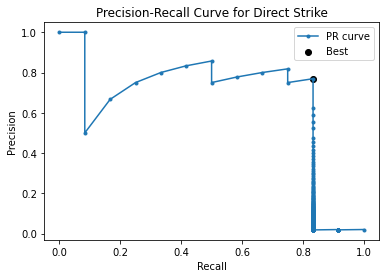

In [15]:
calibration_plot(calibrated_mlp_clf, dev_X, dev_Y)
best_thresholds, best_f1_scores = optimize_thresholds(calibrated_mlp_clf, dev_X, dev_Y)
preds = predictions_with_thresholds(calibrated_mlp_clf, best_thresholds, dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [14]:
save_sklearn_model_to_file(mlp_clf, "downsampled_mlpregr")

## Group 3: sktime

In [97]:
# special data preprocessing for sktime
from sktime.transformations.panel.compose import ColumnConcatenator
PAST_TRACK_LIMIT = 24

def convert_X(dataset_X):
    '''Takes in a (n_samples, n_features) Pandas dataframe and returns it in shape (n_samples, n_features, time_series_length)'''
    processed_samples = 0
    new_dataset = []
    for index, row in dataset_X.iterrows():
        new_row = []

        # obtain time series for each feature        
        for i in range(12): # 10 for baseline_dataset_ts_24, 12 for tsnv
            feature_name = dataset_X.columns[i][:-2]
            feature_series = []
            for j in range(0, PAST_TRACK_LIMIT+6, 6):        
                feature_series.append(row.loc["{0}{1:02d}".format(feature_name, j)]) # access by column name
            feature_series.reverse() # newest data come last
            feature_series = pd.Series(data=feature_series) # correct type for each cell
            new_row.append(feature_series)

        # new_row = pd.Series(data=new_row, index=new_features)
        new_dataset.append(new_row)
        processed_samples += 1

        if processed_samples % 1000 == 0:
            print("Finished concatenating {0}/{1} samples...".format(processed_samples, dataset_X.shape[0]))
            
    # convert types back
    # converted_X = pd.DataFrame(new_dataset, columns=new_features)
    converted_X = np.array(new_dataset)
    print("Completed")
    return converted_X

concat_train_X = convert_X(train_X)
concat_dev_X = convert_X(dev_X)
print("Before transform:", concat_train_X.shape)
concat_train_X = ColumnConcatenator().fit_transform(concat_train_X)
concat_dev_X = ColumnConcatenator().fit_transform(concat_dev_X)
print("After transform:", concat_train_X.shape)
print("Each element is:", concat_train_X.iloc[0].iloc[0].shape)

Finished concatenating 1000/5634 samples...
Finished concatenating 2000/5634 samples...
Finished concatenating 3000/5634 samples...
Finished concatenating 4000/5634 samples...
Finished concatenating 5000/5634 samples...
Completed
Completed
Before transform: (5634, 12, 5)
After transform: (5634, 1)
Each element is: (60,)


time series forest classifier  
no tricks: f1-score \[0.83929 0.87059 0.75862 0.75000\] average 0.80462  
with grid search: (3,100) f1-score \[0.83636 0.87640 0.73333 0.81818\] average 0.81607   
but the calibration looks decent to start with.

regressor grid searched score 0.80610.

Best Threshold=0.37000, F-Score=0.87179
Best Threshold=0.45333, F-Score=0.89655
Best Threshold=0.42000, F-Score=0.80000
Best Threshold=0.24667, F-Score=0.76923


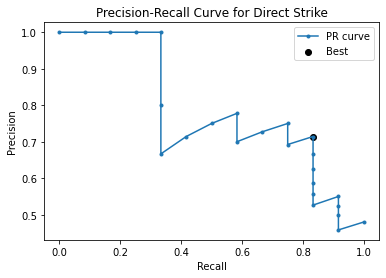

In [105]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.regression.interval_based import TimeSeriesForestRegressor

# tsfs_clf = TimeSeriesForestClassifier(min_interval=3, n_estimators=100, n_jobs=-1, random_state=42)
# tsfs_clf = MultiOutputClassifier(tsfs_clf, n_jobs=-1).fit(concat_train_X, train_Y)
tsfs_clf = MultiOutputRegressor(
    TimeSeriesForestRegressor(n_estimators=300, min_interval=5, n_jobs=-1, random_state=42), n_jobs=-1).fit(concat_train_X, train_Y)

# best_thresholds, best_f1_scores = optimize_thresholds(tsfs_clf, concat_dev_X, dev_Y)
best_thresholds, best_f1_scores = regressor_find_thresholds(tsfs_clf, concat_dev_X, dev_Y)

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.027862
Class 1, no calibration: 0.020869
Class 2, no calibration: 0.010586
Class 3, no calibration: 0.009261


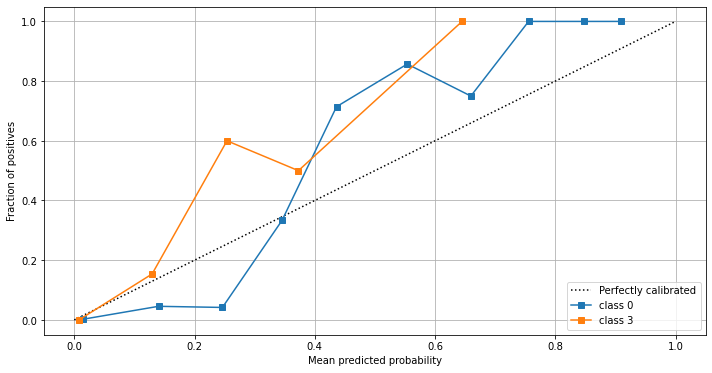

In [106]:
calibration_plot(tsfs_clf, concat_dev_X, dev_Y)

In [107]:
# preds = predictions_with_thresholds(tsfs_clf, best_thresholds, concat_dev_X)
preds = regression_label(tsfs_clf, concat_dev_X, best_thresholds)

print(classification_report(dev_Y, preds, zero_division=0, digits=5))

              precision    recall  f1-score   support

           0    0.84746   0.87719   0.86207        57
           1    0.92683   0.84444   0.88372        45
           2    0.84615   0.68750   0.75862        16
           3    0.69231   0.75000   0.72000        12

   micro avg    0.85714   0.83077   0.84375       130
   macro avg    0.82819   0.78978   0.80610       130
weighted avg    0.86045   0.83077   0.84372       130
 samples avg    0.08546   0.08519   0.08351       130



#### GS
(classifier)  
min_interval: from 2-6, best value 3 or 5, but let's say 3  
n_estimators: from 50-250, best value somewhere between 50-100, but let's say 50  
nested dataframes are a birch.

In [103]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sktime.regression.interval_based import TimeSeriesForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

# tsfs_clf = MultiOutputClassifier(TimeSeriesForestClassifier(min_interval=5, n_jobs=-1, random_state=42), n_jobs=-1)
tsfs_clf = MultiOutputRegressor(TimeSeriesForestRegressor(min_interval=5, n_jobs=-1, random_state=42), n_jobs=-1)

params_grid = { "estimator__n_estimators": [250, 300, 350] }

# scorer = make_scorer(f1_score, zero_division=0, average='macro')

def my_scorer(y_true, y_pred):
    '''Returns the average f1 scores for the given label y_true and continuous y_pred.'''
    y_pred = np.clip(y_pred, 0, 1)
    best_thresholds = []
    for i in range(4):
        precision, recall, thresholds = precision_recall_curve(y_true[:,i], y_pred[:,i])
        fscore = (2 * precision * recall) / (precision + recall)
        ix = np.nanargmax(fscore)
        best_thresholds.append(thresholds[ix])
    preds = []
    for i in range(len(y_pred)):
        pred_row = []
        for j in range(4):
            if y_pred[i,j] > best_thresholds[j]:
                pred_row.append(1)
            else:
                pred_row.append(0)
        preds.append(pred_row)
    return f1_score(y_true, preds, zero_division=0, average='macro')
scorer = make_scorer(my_scorer)

gscv = GridSearchCV(tsfs_clf, params_grid, scoring=scorer, n_jobs=-1, refit=False, cv=3, verbose=4, error_score=0.0).fit(concat_train_X, train_Y)

Fitting 3 folds for each of 3 candidates, totalling 9 fits


In [104]:
gscv.cv_results_

{'mean_fit_time': array([61.97049387, 75.48820599, 67.65692838]),
 'std_fit_time': array([ 0.21471849,  0.81760233, 23.88475052]),
 'mean_score_time': array([15.34091083, 15.75937915, 13.10550292]),
 'std_score_time': array([0.58433041, 0.31151885, 3.54967116]),
 'param_estimator__n_estimators': masked_array(data=[250, 300, 350],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'estimator__n_estimators': 250},
  {'estimator__n_estimators': 300},
  {'estimator__n_estimators': 350}],
 'split0_test_score': array([0.70325702, 0.71388116, 0.71231188]),
 'split1_test_score': array([0.67733565, 0.68824858, 0.68872142]),
 'split2_test_score': array([0.71197564, 0.71859309, 0.71892253]),
 'mean_test_score': array([0.69752277, 0.70690761, 0.70665194]),
 'std_test_score': array([0.01471152, 0.01333342, 0.01296284]),
 'rank_test_score': array([3, 1, 2], dtype=int32)}

#### Calibration?
If it wants to fit, that is

In [169]:
from sktime.classification.interval_based import TimeSeriesForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier

# base estimator
tsfs_clf = TimeSeriesForestClassifier(min_interval=3, n_estimators=100, n_jobs=-1, random_state=42)
tsfs_clf = OneVsRestClassifier(tsfs_clf, n_jobs=-1)
# calibrated estimator
tsfs_clf = CalibratedClassifierCV(base_estimator=tsfs_clf, cv=3, n_jobs=-1, ensemble=False)
tsfs_clf = MultiOutputClassifier(tsfs_clf, n_jobs=-1).fit(concat_train_X, train_Y)

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:50: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_hierarchical/_check.py:51: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_MULTIINDEX_TYPES = (

Brier score losses: (the smaller the better)


/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd.RangeIndex, pd.PeriodIndex, pd.DatetimeIndex)
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/sktime/datatypes/_series/_check.py:43: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  VALID_INDEX_TYPES = (pd.Int64Index, pd

Class 0, no calibration: 0.023732
Class 1, no calibration: 0.014732
Class 2, no calibration: 0.009808
Class 3, no calibration: 0.005299


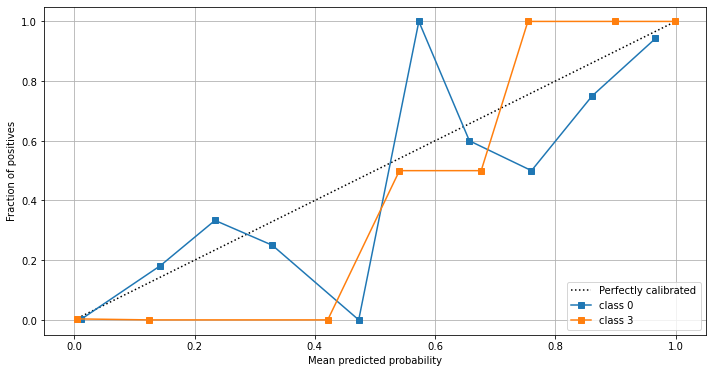

Best Threshold=0.53057, F-Score=0.84685
Best Threshold=0.46525, F-Score=0.88889
Best Threshold=0.63891, F-Score=0.77419
Best Threshold=0.56468, F-Score=0.86957
              precision    recall  f1-score   support

           0    0.86792   0.80702   0.83636        57
           1    0.88636   0.86667   0.87640        45
           2    0.78571   0.68750   0.73333        16
           3    0.90000   0.75000   0.81818        12

   micro avg    0.86777   0.80769   0.83665       130
   macro avg    0.86000   0.77780   0.81607       130
weighted avg    0.86715   0.80769   0.83586       130
 samples avg    0.08001   0.07961   0.07837       130



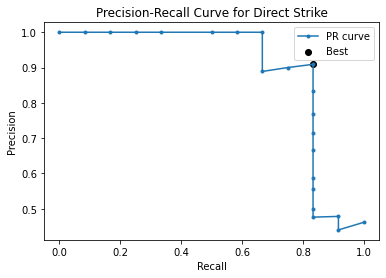

In [170]:
calibration_plot(tsfs_clf, concat_dev_X, dev_Y)
best_thresholds, best_f1_scores = optimize_thresholds(tsfs_clf, concat_dev_X, dev_Y)
preds = predictions_with_thresholds(tsfs_clf, best_thresholds, concat_dev_X)
print(classification_report(dev_Y, preds, zero_division=0, digits=5))

In [108]:
save_sklearn_model_to_file(tsfs_clf, "downsampled_gscv_tsfs_regr")

[CV 2/3] END .........estimator__min_interval=2;, score=0.638 total time=  15.4s
[CV 3/3] END .........estimator__min_interval=4;, score=0.695 total time=  15.4s
[CV 2/3] END ........estimator__n_estimators=50;, score=0.646 total time=  17.2s
[CV 2/3] END .......estimator__n_estimators=200;, score=0.674 total time=  57.4s
[CV 1/3] END .......estimator__n_estimators=300;, score=0.714 total time= 1.5min
[CV 1/3] END .........estimator__min_interval=2;, score=0.685 total time=  16.0s
[CV 1/3] END .........estimator__min_interval=5;, score=0.689 total time=  15.5s
[CV 1/3] END .......estimator__n_estimators=100;, score=0.699 total time=  33.0s
[CV 2/3] END .......estimator__n_estimators=250;, score=0.677 total time=  58.9s
[CV 1/3] END .......estimator__n_estimators=350;, score=0.712 total time= 1.7min
[CV 3/3] END .........estimator__min_interval=3;, score=0.641 total time=  16.6s
[CV 2/3] END .........estimator__min_interval=6;, score=0.651 total time=  13.9s
[CV 1/3] END .......estimato

## Group 4: Linear models and GAMs
The only way these things can work is to compute polynomial features and then select from them. It's just that this little maneuver will take us a horrendously long time. As such, working configurations from the experimental models are reused here.

Linear, K=100, N=1 w/ powers, n_splines=60, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.84615 0.82979 0.81250 0.81818\] average 0.82666  
Linear, K=125, N=1 w/ powers, n_splines=60, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[**0.88679** **0.86022** 0.80000 **0.86957**\] average 0.85414   
Linear, K=137, N=1 w/ powers, n_splines=20, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.86239 0.81818 0.75862 0.83333\] average 0.81813   
Linear, K=137, N=2 w/ powers, n_splines=20, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.84404 0.79121 0.70000 0.72000\] average 0.76381  
Linear, K=150, N=1 w/ powers, n_splines=20, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.86726 0.82759 0.77419 0.85714\] average 0.83154  
Linear, K=137, N=1 w/ powers, n_splines=40, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.87179 0.80488 0.81481 0.85714\] average 0.83716  
Linear, K=137, N=1 w/ powers, n_splines=60, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.87500 0.85417 **0.82353** 0.86957\] average **0.85557**   
Linear, K=150, N=1 w/ powers, n_splines=60, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.84615 0.85106 0.82353 0.80000\] average 0.83019  
Poisson, K=137, N=1 w/o powers, n_splines=20, lam = \[0.6, 0.6, 6.0, 6.0\]: f1-score \[0.88525 0.80851 0.75862 0.60000\] average 0.76309  

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1308.1404
Link Function:                     IdentityLink Log Likelihood:                                 -52891.427
Number of Samples:                         5634 AIC:                                           108401.1348
                                                AICc:                                          109194.4805
                                                GCV:                                                0.0544
                                                Scale:                                              0.0323
                                                Pseudo R-Squared:                                   0.7318
Feature Function                  Lam

/tmp/.u3556490/ipykernel_17013/1154648328.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1455.3888
Link Function:                     IdentityLink Log Likelihood:                                -78760.0331
Number of Samples:                         5634 AIC:                                           160432.8438
                                                AICc:                                          161449.2298
                                                GCV:                                                  0.04
                                                Scale:                                               0.022
                                                Pseudo R-Squared:                                   0.7428
Feature Function                  Lam

/tmp/.u3556490/ipykernel_17013/1154648328.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1138.7886
Link Function:                     IdentityLink Log Likelihood:                                -141073.049
Number of Samples:                         5634 AIC:                                           284425.6751
                                                AICc:                                          285004.4406
                                                GCV:                                                0.0218
                                                Scale:                                              0.0141
                                                Pseudo R-Squared:                                   0.6146
Feature Function                  Lam

/tmp/.u3556490/ipykernel_17013/1154648328.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1193.6283
Link Function:                     IdentityLink Log Likelihood:                               -209888.8938
Number of Samples:                         5634 AIC:                                           422167.0442
                                                AICc:                                          422810.6728
                                                GCV:                                                0.0153
                                                Scale:                                              0.0096
                                                Pseudo R-Squared:                                   0.5932
Feature Function                  Lam

/tmp/.u3556490/ipykernel_17013/1154648328.py:32: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(627, 4)
Best Threshold=0.63577, F-Score=0.85714
Best Threshold=0.59857, F-Score=0.84211
Best Threshold=0.58915, F-Score=0.84848
Best Threshold=0.58448, F-Score=0.86957
              precision    recall  f1-score   support

           0    0.93617   0.77193   0.84615        57
           1    0.79592   0.86667   0.82979        45
           2    0.81250   0.81250   0.81250        16
           3    0.90000   0.75000   0.81818        12

   micro avg    0.86066   0.80769   0.83333       130
   macro avg    0.86115   0.80027   0.82666       130
weighted avg    0.86906   0.80769   0.83376       130
 samples avg    0.07948   0.07921   0.07722       130



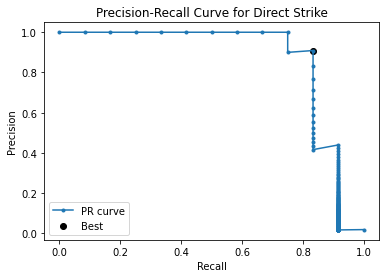

In [19]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s, PoissonGAM
from scipy.special import expit
from functools import partial

N_STEPS = 1
K = 100
lam = [0.6, 0.6, 6.0, 6.0]
n_splines=60
power_terms = True
all_fs = []
all_gams = []

# poly generation step
poly = PolynomialFeatures(degree=3, interaction_only=(not power_terms), include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:(13*N_STEPS)])

for i in range(4):  
    terms = s(0, lam=lam[i], n_splines=n_splines)
    for j in range(1,K):
        terms += s(j, lam=lam[i], n_splines=n_splines)
        
    # feature selection step
    fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=K)
    fs.fit(transformed_X, train_Y[:,i])
    fs_X = fs.transform(transformed_X)
    all_fs.append(fs)
    
    # GAM fitting step           
    gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,i])
    print(gam.summary())
    all_gams.append(gam)
    
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = all_fs[i].transform(poly.transform(dev_X.iloc[:,:(13*N_STEPS)]))
    preds = expit(all_gams[i].predict(tr_dev_X))
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds, best_f1_scores = regressor_find_thresholds(all_gams, dev_X, dev_Y, probs_given=True, probs=raw_preds)
    
preds = regression_label(all_gams, dev_X, best_thresholds, probs_given=True, probs=raw_preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

#### Build and test model

In [11]:
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from pygam import LinearGAM, s
from scipy.special import expit
from functools import partial

model = dict()
all_poly = []
all_fs = []
all_gams = []

# target 0: Linear, K=125, N=1 w/ powers, n_splines=60
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:13])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=125)
fs.fit(transformed_X, train_Y[:,0])
fs_X = fs.transform(transformed_X)
all_fs.append(fs)

terms = s(0, lam=0.6, n_splines=60)
for j in range(1,125):
    terms += s(j, lam=0.6, n_splines=60)
gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,0])
print(gam.summary())
all_gams.append(gam)    

# target 1: same as above
transformed_X = poly.fit_transform(train_X.iloc[:,:13])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=125)
fs.fit(transformed_X, train_Y[:,1])
fs_X = fs.transform(transformed_X)
all_fs.append(fs)

gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,1])
print(gam.summary())
all_gams.append(gam)    

# target 2: Linear, K=137, N=1 w/ powers, n_splines=60
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:13])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=137)
fs.fit(transformed_X, train_Y[:,2])
fs_X = fs.transform(transformed_X)
all_fs.append(fs)

terms = s(0, lam=6.0, n_splines=60)
for j in range(1,137):
    terms += s(j, lam=6.0, n_splines=60)
gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,2])
print(gam.summary())
all_gams.append(gam)

# target 3: Linear, K=125, N=1 w/ powers, n_splines=60
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
transformed_X = poly.fit_transform(train_X.iloc[:,:13])
all_poly.append(poly)

fs = SelectKBest(score_func=partial(mutual_info_classif, random_state=42), k=125)
fs.fit(transformed_X, train_Y[:,3])
fs_X = fs.transform(transformed_X)
all_fs.append(fs)

terms = s(0, lam=6.0, n_splines=60)
for j in range(1,125):
    terms += s(j, lam=6.0, n_splines=60)
gam = LinearGAM(terms,max_iter=1000, verbose=True).fit(fs_X, train_Y[:,3])
print(gam.summary())
all_gams.append(gam)

model["poly"] = all_poly
model["fs"] = all_fs
model["gam"] = all_gams

/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1613.2658
Link Function:                     IdentityLink Log Likelihood:                                -56964.2612
Number of Samples:                         5634 AIC:                                            117157.054
                                                AICc:                                          118454.7106
                                                GCV:                                                0.0556
                                                Scale:                                              0.0279
                                                Pseudo R-Squared:                                   0.7841
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6515/4198692438.py:26: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                    1298.907
Link Function:                     IdentityLink Log Likelihood:                                -87271.9612
Number of Samples:                         5634 AIC:                                           177143.7365
                                                AICc:                                          177924.2682
                                                GCV:                                                 0.035
                                                Scale:                                              0.0209
                                                Pseudo R-Squared:                                   0.7466
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6515/4198692438.py:39: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1001.9569
Link Function:                     IdentityLink Log Likelihood:                               -137717.2823
Number of Samples:                         5634 AIC:                                           277440.4784
                                                AICc:                                          277875.4314
                                                GCV:                                                0.0216
                                                Scale:                                              0.0148
                                                Pseudo R-Squared:                                   0.5812
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6515/4198692438.py:56: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())
/userhome/cs/u3556490/anaconda3/envs/test/lib/python3.9/site-packages/pygam/utils.py:78: UserWarning: Could not import Scikit-Sparse or Suite-Sparse.
This will slow down optimization for models with monotonicity/convexity penalties and many splines.
See installation instructions for installing Scikit-Sparse and Suite-Sparse via Conda.
  warnings.warn(msg)


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                   1069.5605
Link Function:                     IdentityLink Log Likelihood:                               -211276.3534
Number of Samples:                         5634 AIC:                                           424693.8278
                                                AICc:                                          425196.7036
                                                GCV:                                                0.0148
                                                Scale:                                              0.0098
                                                Pseudo R-Squared:                                   0.5725
Feature Function                  Lam

/tmp/.u3556490/ipykernel_6515/4198692438.py:73: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  print(gam.summary())


(627, 4)
Best Threshold=0.51311, F-Score=0.89720
Best Threshold=0.36747, F-Score=0.83871
Best Threshold=0.34045, F-Score=0.85714
Best Threshold=0.32873, F-Score=0.91667
              precision    recall  f1-score   support

           0    0.95918   0.82456   0.88679        57
           1    0.80851   0.84444   0.82609        45
           2    0.77778   0.87500   0.82353        16
           3    0.90909   0.83333   0.86957        12

   micro avg    0.87200   0.83846   0.85490       130
   macro avg    0.86364   0.84433   0.85149       130
weighted avg    0.88008   0.83846   0.85640       130
 samples avg    0.08054   0.08280   0.07997       130

Brier score losses: (the smaller the better)
Class 0, no calibration: 0.024636
Class 1, no calibration: 0.022828
Class 2, no calibration: 0.010382
Class 3, no calibration: 0.007072


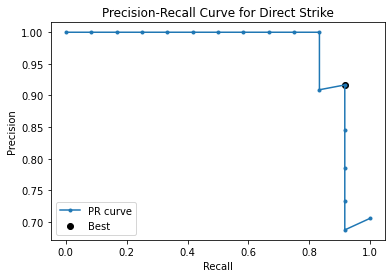

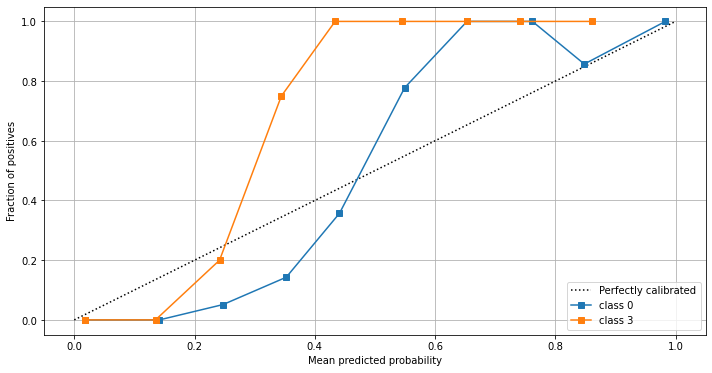

In [12]:
# scoring step
raw_preds = []
for i in range(4):
    tr_dev_X = model["fs"][i].transform(model["poly"][i].transform(dev_X.iloc[:,:13]))
    # preds = expit(model["gam"][i].predict(tr_dev_X))
    preds = np.clip(model["gam"][i].predict(tr_dev_X),0,1)
    raw_preds.append(preds)
raw_preds = np.stack(raw_preds, axis=1)
print(raw_preds.shape)

best_thresholds, best_f1_scores = regressor_find_thresholds(model, dev_X, dev_Y, probs_given=True, probs=raw_preds)
    
preds = regression_label(model, dev_X, best_thresholds, probs_given=True, probs=raw_preds)

print(classification_report(dev_Y, preds, digits=5, zero_division=0))

calibration_plot(model, dev_X, dev_Y, probs_given=True, probs=raw_preds)

In [13]:
# save to file
import pickle as pk
from datetime import datetime

pk.dump(model, open("./models/baseline_model_downsampled_gam_{}.pkl".format(str(datetime.now().strftime("%Y-%m-%d %H-%M"))), 'wb'))